In [1]:
import sys

sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'
DATA_PATH = 'D:\\Trading\\trading-agent\\crypto-pair-trading\\data/1h'

In [3]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'DOT', 'LUNA', 'UNI', 'LINK', 'BCH', 'LTC', 'ALGO', 'AVAX', 'ICP', 'WBTC', 'FTT', 'MATIC', 'FIL', 'XLM', 'VET', 'ETC', 'TRX', 'THETA']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2021-05-01'
end_date = '2021-08-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        df = df[(df.index > start_date) & (df.index < end_date)]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOGE-USDT,DOT-USDT,LUNA-USDT,UNI-USDT,...,AVAX-USDT,ICP-USDT,FTT-USDT,MATIC-USDT,FIL-USDT,XLM-USDT,VET-USDT,ETC-USDT,TRX-USDT,THETA-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2021-07-31 19:00:00,10.628706,7.806534,0.264362,5.801816,3.537475,-0.292226,-1.574988,2.798500,2.375650,3.052160,...,2.556219,3.732657,3.545067,0.044304,3.940222,-1.259662,-2.434746,3.921379,-2.752472,1.804017
2021-07-31 20:00:00,10.633717,7.820279,0.268881,5.807061,3.549991,-0.288616,-1.570794,2.815109,2.388304,3.066563,...,2.580141,3.739573,3.552172,0.050027,3.945264,-1.252008,-2.431897,3.932355,-2.746999,1.809927
2021-07-31 21:00:00,10.644517,7.838619,0.279070,5.821062,3.584629,-0.279449,-1.563127,2.833037,2.390962,3.085436,...,2.592041,3.754433,3.567474,0.062148,3.952205,-1.246289,-2.411954,3.945787,-2.739696,1.814173
2021-07-31 22:00:00,10.642180,7.838485,0.280280,5.822839,3.587788,-0.283823,-1.564130,2.830681,2.388304,3.087126,...,2.604466,3.748091,3.567333,0.083790,3.960242,-1.243650,-2.408835,3.943405,-2.740005,1.804182
2021-07-31 23:00:00,10.632529,7.836390,0.277101,5.806279,3.603975,-0.293030,-1.571901,2.820426,2.373509,3.080395,...,2.604540,3.736955,3.559568,0.079236,3.951628,-1.258007,-2.412177,3.938158,-2.749497,1.808617


In [4]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    # print("trace_crit_value",trace_crit_value)
    # print("eigen_crit_value",eigen_crit_value)
    # print("lr1",result.lr1)
    # print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [5]:

import itertools as it

nb_symbols = 3
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except KeyError:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2,sid_3
0,"[5.563663112235158, -14.669440308489737, 10.28...",BTC-USDT,ETH-USDT,ADA-USDT
1,"[17.100915388893654, -29.309288923048918, 17.4...",BTC-USDT,ETH-USDT,UNI-USDT
2,"[7.026991242119373, 3.133424919320606, -2.4563...",BTC-USDT,ADA-USDT,SOL-USDT
3,"[8.920602751286037, 16.929249928467875, -11.98...",BTC-USDT,ADA-USDT,XRP-USDT
4,"[8.409703044838462, 17.478685693156663, -10.08...",BTC-USDT,ADA-USDT,DOT-USDT


In [6]:
coint_df.to_csv('coint_df.csv')


In [7]:
def calculate_spread(selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        selected_row = i
        hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
        spread = calculate_spread(selected_row, hedge_ratio)
        adf_p = adf_test(spread, verbose=False)
        pp_p = pp_test(spread, verbose=False)
        kpss_p = kpss_test(spread, verbose=False)

        if adf_p < critical_val and pp_p < critical_val and kpss_p > critical_val:
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[0].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
stationary_df.sort_values(by=['half_life'], inplace=True)
stationary_df

C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-pack

,i,pairs,half_life
233,342,"[BTC-USDT, ETH-USDT, ADA-USDT]",12.751025
197,295,"[BTC-USDT, ETH-USDT, ADA-USDT]",18.930848
143,206,"[BTC-USDT, ETH-USDT, ADA-USDT]",20.870746
64,112,"[BTC-USDT, ETH-USDT, ADA-USDT]",23.749394
88,138,"[BTC-USDT, ETH-USDT, ADA-USDT]",27.006016
...,...,...,...
14,22,"[BTC-USDT, ETH-USDT, ADA-USDT]",311.929294
32,71,"[BTC-USDT, ETH-USDT, ADA-USDT]",323.598299
9,14,"[BTC-USDT, ETH-USDT, ADA-USDT]",325.467685
252,373,"[BTC-USDT, ETH-USDT, ADA-USDT]",342.216499


In [8]:
selected_row = stationary_df['i'].iloc[0]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(selected_row, hedge_ratio)

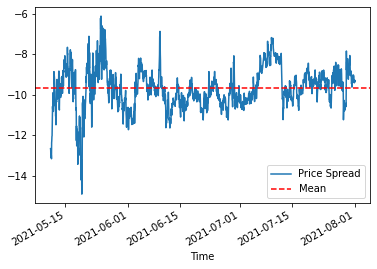

In [9]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

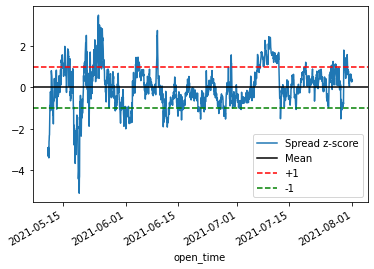

In [11]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])